In [83]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from matplotlib import pyplot as plt

# 导入数据

In [84]:
trans = transforms.ToTensor()
train_data = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
test_data = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [85]:
def get_label(i):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return text_labels[i]

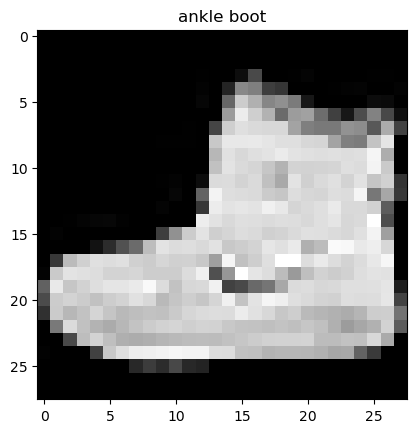

In [86]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title(get_label(train_data.targets[0]))
plt.show()

In [87]:
loaders = {
    'train' : data.DataLoader(train_data, 
                              batch_size=100, 
                              shuffle=True, 
                              num_workers=1),
    
    'test'  : data.DataLoader(test_data, 
                              batch_size=100, 
                              shuffle=True, 
                              num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1ad89fcc040>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1ad89fccaf0>}

In [88]:
for X, y in loaders['test']:
    print(X.shape)
    break

torch.Size([100, 1, 28, 28])


In [89]:
from torch import nn
import torch.nn.functional as F

In [90]:
sequence_length = 28
# 序列长度
input_size = 28
# 每个序列的输入数
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [91]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        pass
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out, hidden = self.rnn(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out
       

model = RNN(input_size, hidden_size, num_layers, num_classes)
print(model)

RNN(
  (rnn): RNN(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [92]:
loss_func = nn.CrossEntropyLoss()

In [93]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [94]:
def train(num_epochs, model, loaders):
        
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            images = images.reshape(-1, sequence_length, input_size)
            labels = labels
            
            outputs = model(images)
            loss = loss_func(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                

train(num_epochs, model, loaders)

AttributeError: 'tuple' object has no attribute 'dim'

In [ ]:
for images, labels in loaders['test']:
    images = images.reshape(-1, sequence_length, input_size)
    outputs = model(images)
    print(outputs.shape)
    break;

In [70]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        images = images.reshape(-1, sequence_length, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total = total + labels.size(0)
        correct = correct + (predicted == labels).sum().item()
print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 85.74 %
